In [30]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import patches as patches
from scipy.misc import bytescale

import rasterio
from rasterio.mask import mask
import os,sys
import fiona

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
from planet_helper_functions import *

In [33]:
# extract the data. it will be a bunch of lists
home_dir = r"C:\Projects\RD\planet\sample_order"
shp = r"C:\Projects\rd\planet\proj_cc_sites.shp"
polys = getGeometries_planet(shp)


# get the centroids of the polygons and buffer them
# convert to centroids
centroids = [shape(p).centroid for p in polys]

# buffer out buffer_distance*2 meters total. square capping.
buffer_distance = 300.
buffer_p = [c.buffer(buffer_distance, cap_style=3) for c in centroids]

# convert them back to geojson
buffers = [mapping(b) for b in buffer_p]


res = [meanIntensityOverGeometry(home_dir, poly) for poly in buffers]

In [56]:
plot_ind=0

# fit it on the first image
test_image = res[plot_ind]['sr_image'][1]
junk = np.rollaxis(test_image, 0,3).astype('float32')

TestData = junk.reshape(-1,4)
ndvi = np.expand_dims(((TestData[:,3] - TestData[:,2]) / (TestData[:,3] + TestData[:,2])), axis=1)
ndvi[np.isnan(ndvi)] = -9999
#TestData = np.hstack((TestData, ndvi))

raw_data = TestData[:,[3,2,1]].T
raw_data = TestData.T


C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:8: RuntimeWarning: invalid value encountered in divide


#### the above crashes (if using somoclu)

In [118]:
#raw_data = np.random.randint(0, 255, (3, 100))
network_dimensions = np.array([25, 25])
n_iterations = 10000
init_learning_rate = 0.01

In [119]:
# establish variables based on data
m = raw_data.shape[0]
n = raw_data.shape[1]

# initial neighbourhood radius
init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
# radius decay parameter
time_constant = n_iterations / np.log(init_radius)

data = raw_data
# check if data needs to be normalised
normalise_data=True
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = raw_data.max(axis=0)
        data = raw_data / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data = raw_data / data.max()

In [120]:
# setup random weights between 0 and 1
# weight matrix needs to be one m-dimensional vector for each neuron in the SOM
net = np.random.random((network_dimensions[0], network_dimensions[1], m))

#### SOM function definitions

In [121]:
def find_bmu(t, net, m):
    """
        Find the best matching unit for a given vector, t, in the SOM
        Returns: a (bmu, bmu_idx) tuple where bmu is the high-dimensional BMU
                 and bmu_idx is the index of this vector in the SOM
    """
    bmu_idx = np.array([0, 0])
    # set the initial minimum distance to a huge number
    min_dist = np.iinfo(np.int).max    
    # calculate the high-dimensional distance between each neuron and the input
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # don't bother with actual Euclidean distance, to avoid expensive sqrt operation
            sq_dist = np.sum((w - t) ** 2)
            if sq_dist < min_dist:
                min_dist = sq_dist
                bmu_idx = np.array([x, y])
    # get vector corresponding to bmu_idx
    bmu = net[bmu_idx[0], bmu_idx[1], :].reshape(m, 1)
    # return the (bmu, bmu_idx) tuple
    return (bmu, bmu_idx)

def decay_radius(initial_radius, i, time_constant):
    return initial_radius * np.exp(-i / time_constant)

def decay_learning_rate(initial_learning_rate, i, n_iterations):
    return initial_learning_rate * np.exp(-i / n_iterations)

def calculate_influence(distance, radius):
    return np.exp(-distance / (2* (radius**2)))



#### SOM learning

In [122]:
for i in range(n_iterations):
    #print('Iteration %d' % i)
    
    # select a training example at random
    t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))
    
    # find its Best Matching Unit
    bmu, bmu_idx = find_bmu(t, net, m)
    
    # decay the SOM parameters
    r = decay_radius(init_radius, i, time_constant)
    l = decay_learning_rate(init_learning_rate, i, n_iterations)
    
    # now we know the BMU, update its weight vector to move closer to input
    # and move its neighbours in 2-D space closer
    # by a factor proportional to their 2-D distance from the BMU
    for x in range(net.shape[0]):
        for y in range(net.shape[1]):
            w = net[x, y, :].reshape(m, 1)
            # get the 2-D distance (again, not the actual Euclidean distance)
            w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
            # if the distance is within the current neighbourhood radius
            if w_dist <= r**2:
                # calculate the degree of influence (based on the 2-D distance)
                influence = calculate_influence(w_dist, r)
                # now update the neuron's weight using the formula:
                # new w = old w + (learning rate * influence * delta)
                # where delta = input vector (t) - old w
                new_w = w + (l * influence * (t - w))
                # commit the new weight
                net[x, y, :] = new_w.reshape(1, 4)

#### plot the color map

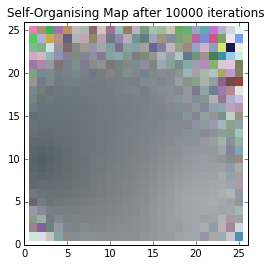

In [123]:
fig = plt.figure()
# setup axes
ax = fig.add_subplot(111, aspect='equal')
ax.set_xlim((0, net.shape[0]+1))
ax.set_ylim((0, net.shape[1]+1))
ax.set_title('Self-Organising Map after %d iterations' % n_iterations)

# plot the rectangles
for x in range(1, net.shape[0] + 1):
    for y in range(1, net.shape[1] + 1):
        ax.add_patch(patches.Rectangle((x-0.5, y-0.5), 1, 1,
                     facecolor=net[x-1,y-1,:],
                     edgecolor='none'))
plt.show()

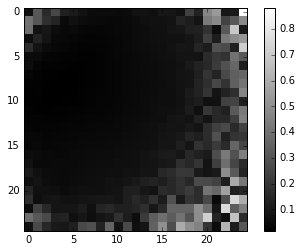

In [124]:
plt.imshow(net[:,:,0], interpolation='nearest', cmap='gray')
plt.colorbar()

In [125]:
sampleV = data[:,1]
s_bmu, s_bmu_idx = find_bmu(sampleV, net, m)
sampleV, s_bmu, s_bmu_idx

(array([ 0.06971154,  0.12680289,  0.18719952,  0.56490386], dtype=float32),
 array([[ 0.31608458],
        [ 0.22530185],
        [ 0.15660277],
        [ 0.34257213]]),
 array([ 5, 24]))

In [126]:
net[5,11]

array([ 0.04661589,  0.10715904,  0.14478492,  0.61998235])

In [127]:
a,b = [],[]
for d in data.T:
    s_bmu, s_bmu_idx = find_bmu(d, net, m)
    a.append(np.sum(s_bmu))
    
len(a)

40000

C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:5: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


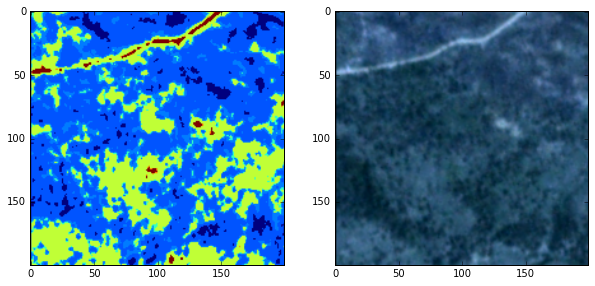

In [128]:
b = np.reshape(np.array(a), (200,200))

fig, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(b)
ax[1].imshow(bytescale(junk[:,:,[0,1,2]]))
plt.show()

# plt.figure(figsize=(10,10))
# plt.imshow(b)
# plt.colorbar()
# plt.show()

C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:6: RuntimeWarning: invalid value encountered in divide
C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:35: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


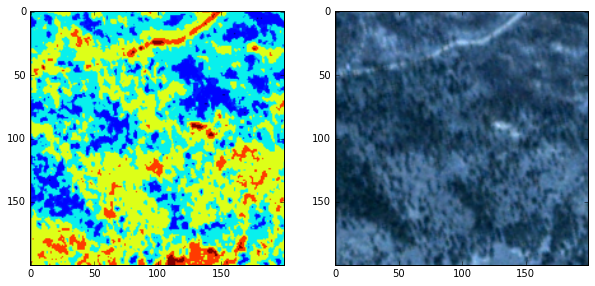

In [129]:
# fit it on the first image
test_image2 = res[plot_ind]['sr_image'][-1]
junk2 = np.rollaxis(test_image2, 0,3).astype('float32')

TestData2 = junk2.reshape(-1,4)
ndvi2 = np.expand_dims(((TestData2[:,3] - TestData2[:,2]) / (TestData2[:,3] + TestData2[:,2])), axis=1)
ndvi2[np.isnan(ndvi)] = -9999
#TestData2 = np.hstack((TestData2, ndvi2))

raw_data2 = TestData2[:,[3,2,1]].T
raw_data2 = TestData2.T

data2 = raw_data2
# check if data needs to be normalised
normalise_data=True
if normalise_data:
    if normalise_by_column:
        # normalise along each column
        col_maxes = raw_data2.max(axis=0)
        data2 = raw_data2 / col_maxes[np.newaxis, :]
    else:
        # normalise entire dataset
        data2 = raw_data2 / data2.max()
        
c = []
for d in data2.T:
    s_bmu, s_bmu_idx = find_bmu(d, net, m)
    c.append(np.sum(s_bmu))
    
    
e = np.reshape(np.array(c), (200,200))

fig, ax = plt.subplots(1,2, figsize = (10,10))
ax[0].imshow(e)
ax[1].imshow(bytescale(junk2[:,:,[0,1,2]]))
plt.show()

C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:59: RuntimeWarning: invalid value encountered in divide


Performing SOM classification for 1 image 2017-08-10 ...


C:\Anaconda2\envs\joemcg_rootclone\lib\site-packages\ipykernel\__main__.py:107: DeprecationWarning: `bytescale` is deprecated!
`bytescale` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.


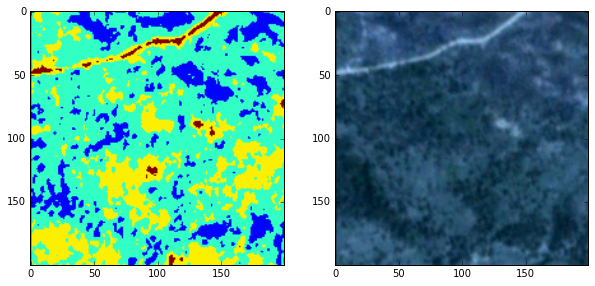

Performing SOM classification for 3 image 2017-08-12 ...


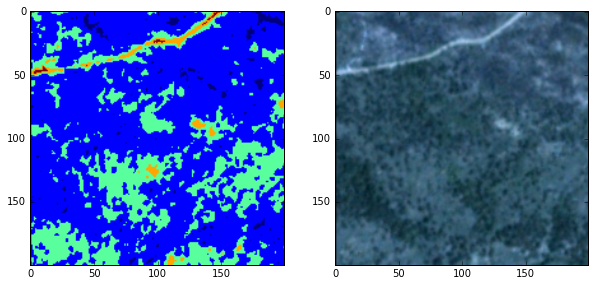

Performing SOM classification for 4 image 2017-08-12 ...


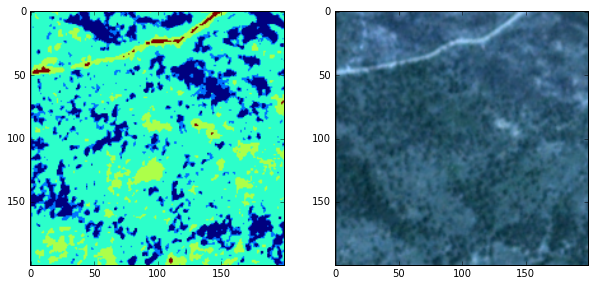

Performing SOM classification for 5 image 2017-08-27 ...


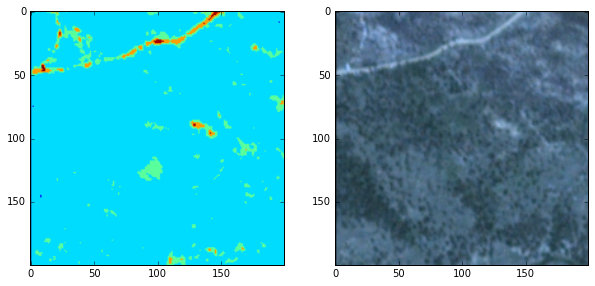

Performing SOM classification for 6 image 2017-09-03 ...


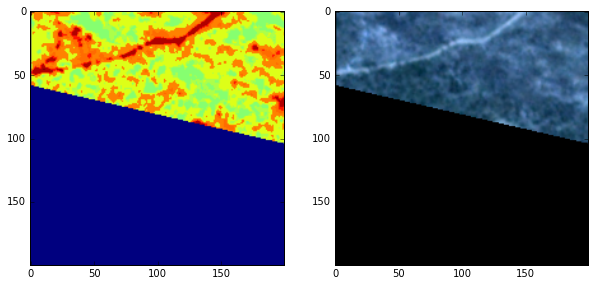

Performing SOM classification for 7 image 2017-09-03 ...


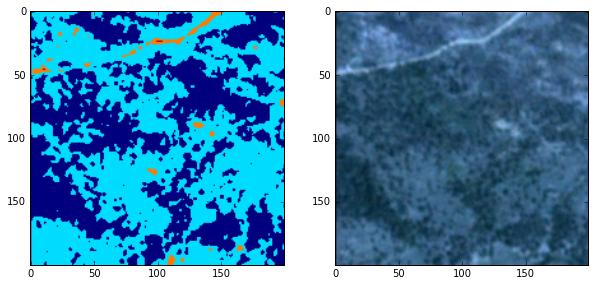

Performing SOM classification for 8 image 2017-09-06 ...


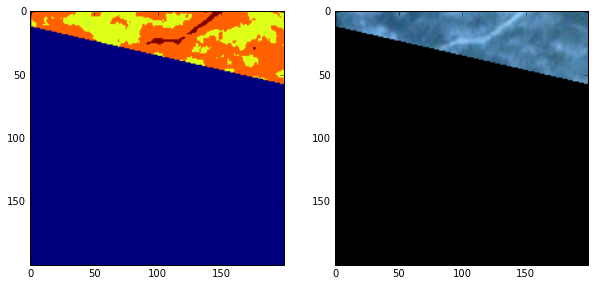

Performing SOM classification for 9 image 2017-09-06 ...


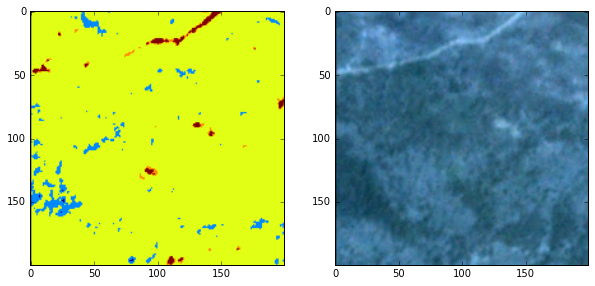

Performing SOM classification for 10 image 2017-09-15 ...


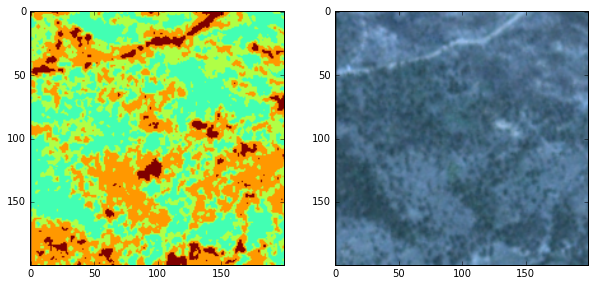

Performing SOM classification for 11 image 2017-09-18 ...


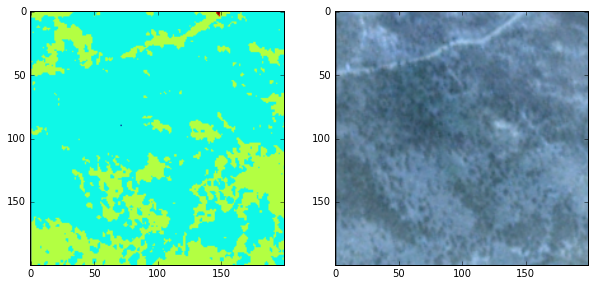

Performing SOM classification for 12 image 2017-09-20 ...


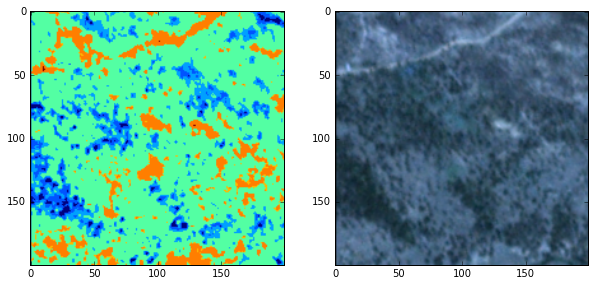

Performing SOM classification for 13 image 2017-09-20 ...


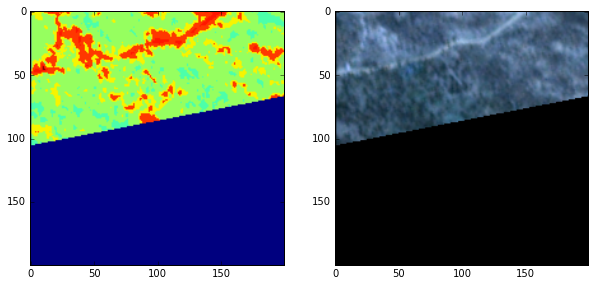

Performing SOM classification for 14 image 2017-09-21 ...


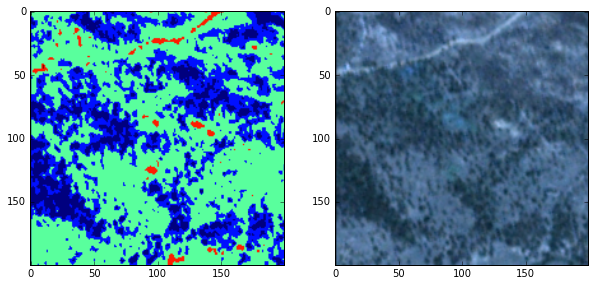

Performing SOM classification for 15 image 2017-10-05 ...


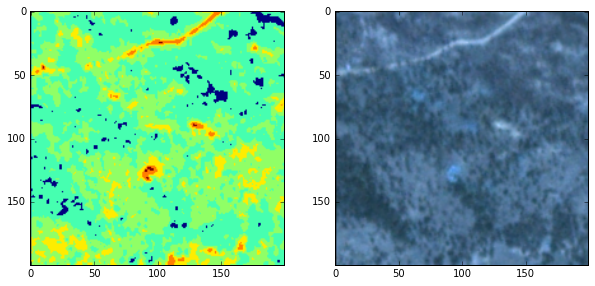

Performing SOM classification for 16 image 2017-10-08 ...


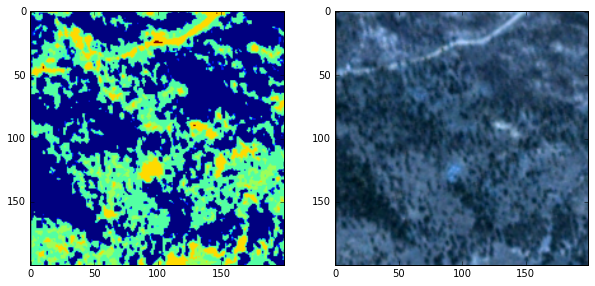

Performing SOM classification for 17 image 2017-10-08 ...


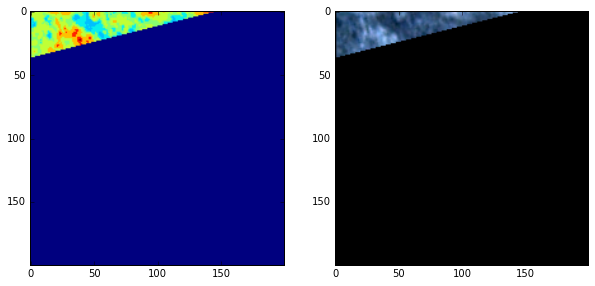

Performing SOM classification for 18 image 2017-10-12 ...


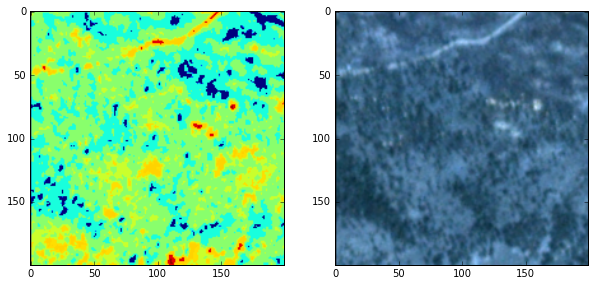

Performing SOM classification for 19 image 2017-10-12 ...


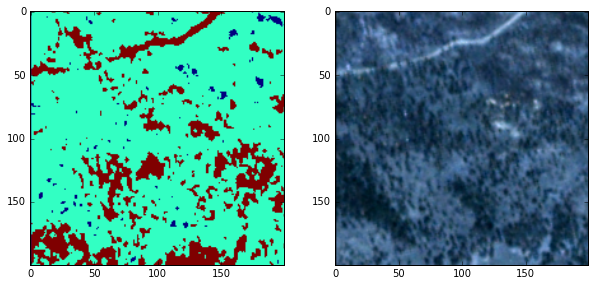

Performing SOM classification for 20 image 2017-10-12 ...


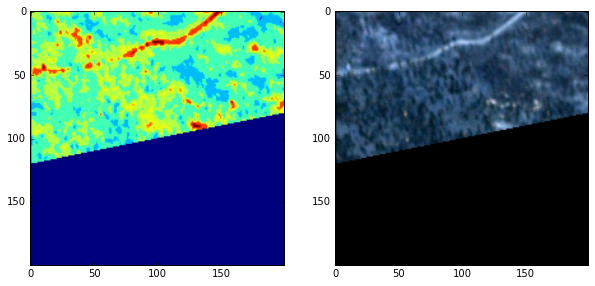

Performing SOM classification for 22 image 2017-10-17 ...


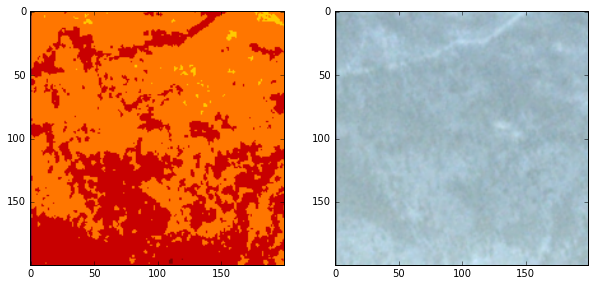

Performing SOM classification for 23 image 2017-10-19 ...


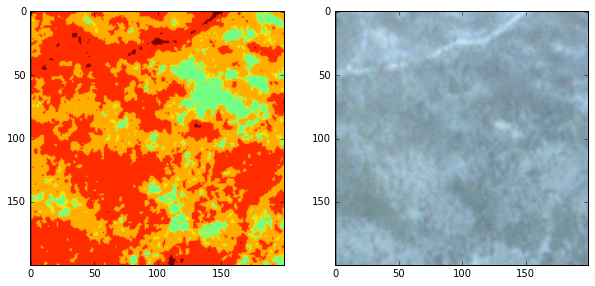

Performing SOM classification for 24 image 2017-10-24 ...


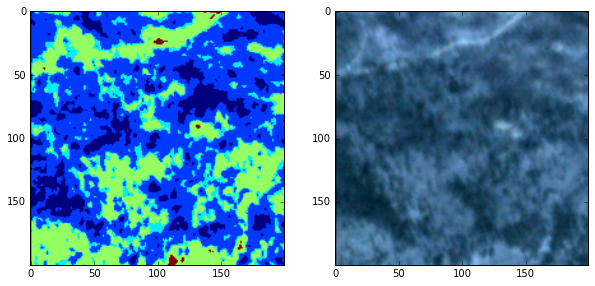

Performing SOM classification for 25 image 2017-10-24 ...


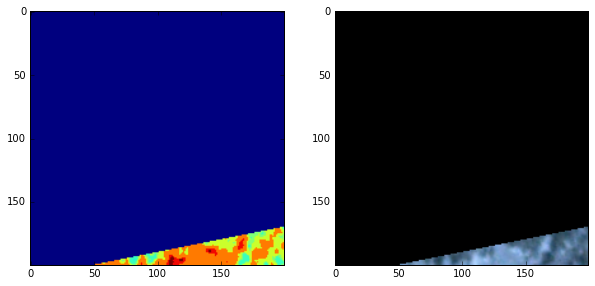

Performing SOM classification for 26 image 2017-10-24 ...


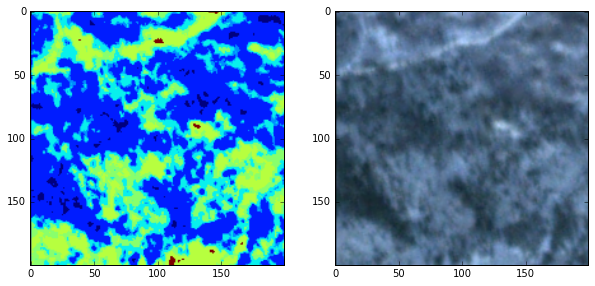

Performing SOM classification for 27 image 2017-10-29 ...


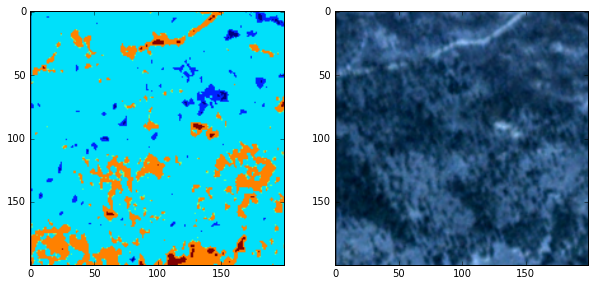

Performing SOM classification for 28 image 2017-10-29 ...


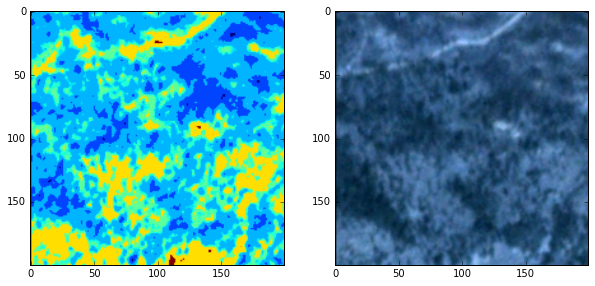

Performing SOM classification for 29 image 2017-10-29 ...


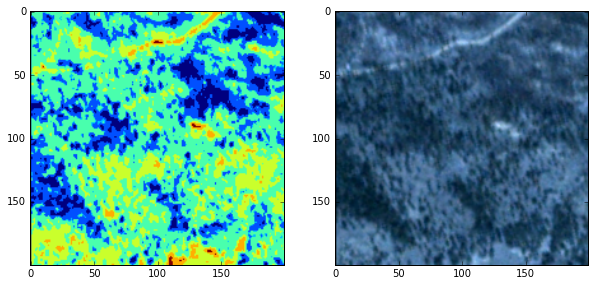

In [135]:
## iterate through all of them (this will take a while)
def run_SOM(net, n_iterations, data):
    
    for i in range(n_iterations):
        #print('Iteration %d' % i)

        # select a training example at random
        t = data[:, np.random.randint(0, n)].reshape(np.array([m, 1]))

        # find its Best Matching Unit
        bmu, bmu_idx = find_bmu(t, net, m)

        # decay the SOM parameters
        r = decay_radius(init_radius, i, time_constant)
        l = decay_learning_rate(init_learning_rate, i, n_iterations)

        # now we know the BMU, update its weight vector to move closer to input
        # and move its neighbours in 2-D space closer
        # by a factor proportional to their 2-D distance from the BMU
        for x in range(net.shape[0]):
            for y in range(net.shape[1]):
                w = net[x, y, :].reshape(m, 1)
                # get the 2-D distance (again, not the actual Euclidean distance)
                w_dist = np.sum((np.array([x, y]) - bmu_idx) ** 2)
                # if the distance is within the current neighbourhood radius
                if w_dist <= r**2:
                    # calculate the degree of influence (based on the 2-D distance)
                    influence = calculate_influence(w_dist, r)
                    # now update the neuron's weight using the formula:
                    # new w = old w + (learning rate * influence * delta)
                    # where delta = input vector (t) - old w
                    new_w = w + (l * influence * (t - w))
                    # commit the new weight
                    net[x, y, :] = new_w.reshape(1, 4)
                
                
    return net


#raw_data = np.random.randint(0, 255, (3, 100))
network_dimensions = np.array([25, 25])
n_iterations = 10000
init_learning_rate = 0.01



plot_ind=0
ctr=0
np.random.seed = 1
for i,data_arr in enumerate(res[plot_ind]['sr_image']):
    
    if np.sum(data_arr) == 0:
        continue
        
    test_image = data_arr
    junk = np.rollaxis(test_image, 0,3).astype('float32')
    
    TestData = junk.reshape(-1,4)
    ndvi = np.expand_dims(((TestData[:,3] - TestData[:,2]) / (TestData[:,3] + TestData[:,2])), axis=1)
    ndvi[np.isnan(ndvi)] = -9999
    #TestData = np.hstack((TestData, ndvi))

    raw_data = TestData[:,[3,2,1]].T
    raw_data = TestData.T
    
    # establish variables based on data
    m = raw_data.shape[0]
    n = raw_data.shape[1]

    # initial neighbourhood radius
    init_radius = max(network_dimensions[0], network_dimensions[1]) / 2
    # radius decay parameter
    time_constant = n_iterations / np.log(init_radius)

    data = raw_data
    # check if data needs to be normalised
    normalise_data=True
    if normalise_data:
        if normalise_by_column:
            # normalise along each column
            col_maxes = raw_data.max(axis=0)
            data = raw_data / col_maxes[np.newaxis, :]
        else:
            # normalise entire dataset
            data = raw_data / data.max()
    
    # setup random weights between 0 and 1
    # weight matrix needs to be one m-dimensional vector for each neuron in the SOM
    net = np.random.random((network_dimensions[0], network_dimensions[1], m))
    
    print("Performing SOM classification for {} image {} ...".format(i, res[plot_ind]['dates'][ctr]))
    
    # fit the SOM
    net = run_SOM(net, n_iterations, data)

    # map the pixels
    a = []
    for d in data.T:
        s_bmu, s_bmu_idx = find_bmu(d, net, m)
        a.append(np.sum(s_bmu))

    
    b = np.reshape(np.array(a), (200,200))

    fig, ax = plt.subplots(1,2, figsize = (10,10))
    ax[0].imshow(b)
    ax[1].imshow(bytescale(junk[:,:,[0,1,2]]))
    plt.show()
    
    
    ctr+=1